<a href="https://colab.research.google.com/github/hejm37/mmediting/blob/add_mat_tutorial/demo/matting_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMEditing Tutorial (Matting)

Welcome to MMEditing! This is the official colab tutorial for using MMEditing for matting task. In this tutorial, you will learn to

* perform inference with a MMEditing mattor,
* train a new mattor with a new dataset.

Let's start!

## Install MMEditing

In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# Install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# Install mmcv from source
!rm -rf mmcv
!git clone https://github.com/open-mmlab/mmcv.git
%cd mmcv
!MMCV_WITH_OPS=1 pip install .
%cd ..

# Install mmediting, it may take a while to install mmcv-full
!rm -rf mmediting
!git clone https://github.com/open-mmlab/mmediting.git
%cd mmediting
!pip install -r requirements.txt
!pip install -e .

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Requirement already up-to-date: torch==1.5.1+cu101 in /usr/local/lib/python3.6/dist-packages (1.5.1+cu101)
Requirement already up-to-date: torchvision==0.6.1+cu101 in /usr/local/lib/python3.6/dist-packages (0.6.1+cu101)
Cloning into 'mmcv'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 3478 (delta 26), reused 15 (delta 6), pack-reused 3410
Receiving objects: 100% (3478/3478), 5.69 MiB | 2.74 MiB/s, done.
Resolving deltas: 100% (2310/2310), done.
/content/mmcv
Processing /content/mmcv
  Created wheel for mmcv-full: filename=mmcv_full-1.0.3-cp36-cp36m-linux_x86_64.whl size=16238614 sha256=931c333a7eaa89e0c0bd6894701a17e515268208e2bad2352ef42a6a4afcd4b4
  Stored in directory: /tmp/pip-ephem-wheel-cache-tiofk6r0/wheels/34/64/a6/92de36f9cc2a71f8e295327009ecfa148ddb9d38beef63ed71
Successfully built mmcv-full
  Found exist

In [3]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMEditing installation
import mmedit
print(mmedit.__version__)

1.5.1+cu101 True
0.5.0+8b5c0c5


## Perform inference with a MMEditing mattor

MMEditing already provides high level APIs to do inference and training.

In [4]:
!mkdir checkpoints
!wget -c https://openmmlab.oss-accelerate.aliyuncs.com/mmediting/mattors/indexnet/indexnet_mobv2_1x16_78k_comp1k_SAD-45.6_20200618_173817-26dd258d.pth \
    -O checkpoints/indexnet_mobv2_1x16_78k_comp1k_SAD-45.6_20200618_173817-26dd258d.pth

--2020-07-20 06:20:48--  https://openmmlab.oss-accelerate.aliyuncs.com/mmediting/mattors/indexnet/indexnet_mobv2_1x16_78k_comp1k_SAD-45.6_20200618_173817-26dd258d.pth
Resolving openmmlab.oss-accelerate.aliyuncs.com (openmmlab.oss-accelerate.aliyuncs.com)... 47.254.186.225
Connecting to openmmlab.oss-accelerate.aliyuncs.com (openmmlab.oss-accelerate.aliyuncs.com)|47.254.186.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24079143 (23M) [application/octet-stream]
Saving to: ‘checkpoints/indexnet_mobv2_1x16_78k_comp1k_SAD-45.6_20200618_173817-26dd258d.pth’

checkpoints/indexne 100%[===================>]  22.96M  10.1MB/s    in 2.3s    

2020-07-20 06:20:51 (10.1 MB/s) - ‘checkpoints/indexnet_mobv2_1x16_78k_comp1k_SAD-45.6_20200618_173817-26dd258d.pth’ saved [24079143/24079143]



In [5]:
from mmedit.apis import matting_inference, init_model

# Choose to use a config and initialize the mattor
config = './configs/mattors/indexnet/indexnet_mobv2_1x16_78k_comp1k.py'
# Setup a checkpoint file to load
checkpoint = './checkpoints/indexnet_mobv2_1x16_78k_comp1k_SAD-45.6_20200618_173817-26dd258d.pth'
# Initialize the recognizer
model = init_model(config, checkpoint, device='cuda:0')

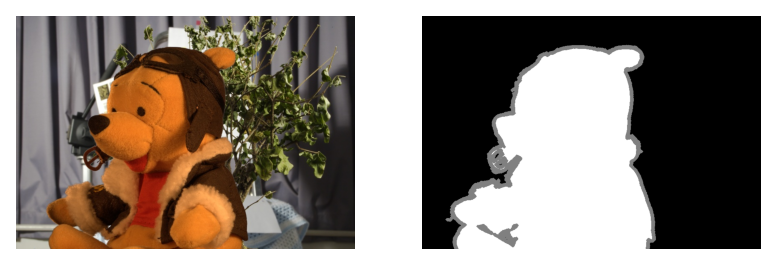

In [6]:
%matplotlib inline 
import mmcv
from matplotlib import pyplot as plt

# Sample images path
merged_path = './tests/data/merged/GT05.jpg'
trimap_path = './tests/data/trimap/GT05.png'

# Plot sample images
merged = mmcv.imread(merged_path)
trimap = mmcv.imread(trimap_path)
f, axarr = plt.subplots(1, 2)
f.dpi = 160
axarr[0].axis('off')
axarr[0].imshow(mmcv.bgr2rgb(merged))
axarr[1].axis('off')
axarr[1].imshow(trimap)

In [7]:
# Use the mattor to do inference
pred_alpha = matting_inference(model, merged_path, trimap_path) * 255

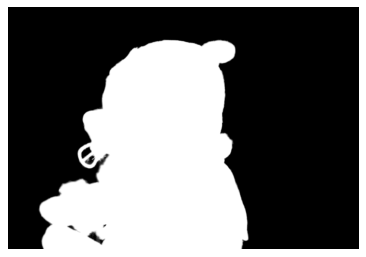

In [8]:
# Plot result
plt.gcf().dpi = 80
plt.axis('off')
plt.imshow(pred_alpha, cmap=plt.get_cmap('gray'))
plt.show()

## Train a mattor on a customized dataset

To train a new mattor, there are usually three things to do:

1. Support a new dataset
2. Modify the config
3. Train a new mattor

### Support a new dataset

In this tutorial, we gives an example to convert the data into the format of existing datasets. 

<!-- TODO: Other methods and more advanced usages can be found in the [doc](TODO). -->

Firstly, let's download the only available open source matting dataset from [alphamatting.com](http://alphamatting.com/). 

In [9]:
!mkdir -p data/alphamatting/
!wget http://alphamatting.com/datasets/zip/input_training_lowres.zip -O data/alphamatting/input_training_lowres.zip
!wget http://alphamatting.com/datasets/zip/trimap_training_lowres.zip -O data/alphamatting/trimap_training_lowres.zip
!wget http://alphamatting.com/datasets/zip/gt_training_lowres.zip -O data/alphamatting/gt_training_lowres.zip
!unzip data/alphamatting/input_training_lowres.zip -d data/alphamatting/merged
!unzip data/alphamatting/trimap_training_lowres.zip -d data/alphamatting/trimap
!unzip data/alphamatting/gt_training_lowres.zip -d data/alphamatting/alpha

--2020-07-20 06:21:03--  http://alphamatting.com/datasets/zip/input_training_lowres.zip
Resolving alphamatting.com (alphamatting.com)... 128.131.167.210
Connecting to alphamatting.com (alphamatting.com)|128.131.167.210|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18218854 (17M) [application/zip]
Saving to: ‘data/alphamatting/input_training_lowres.zip’

data/alphamatting/i 100%[===================>]  17.37M  49.3MB/s    in 0.4s    

2020-07-20 06:21:03 (49.3 MB/s) - ‘data/alphamatting/input_training_lowres.zip’ saved [18218854/18218854]

--2020-07-20 06:21:06--  http://alphamatting.com/datasets/zip/trimap_training_lowres.zip
Resolving alphamatting.com (alphamatting.com)... 128.131.167.210
Connecting to alphamatting.com (alphamatting.com)|128.131.167.210|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375510 (367K) [application/zip]
Saving to: ‘data/alphamatting/trimap_training_lowres.zip’

data/alphamatting/t 100%[===================>

Then we create the annotation file for training data.

In [10]:
num_file = 27
num_training = 20  # use 20 samples for training, 7 for test

training_ann = list()
for i in range(num_training):
  ann = dict()
  ann['merged_path'] = f'merged/GT{i+1:02d}.png'
  ann['alpha_path'] = f'alpha/GT{i+1:02d}.png'
  # since data from alphamatting.com is not composited, we use original image 
  # as fg and bg
  ann['fg_path'] = ann['merged_path']
  ann['bg_path'] = ann['merged_path']
  training_ann.append(ann)

mmcv.dump(training_ann, './data/alphamatting/training_list.json')

Let's create the annotation file for test data in the same way.

In [11]:
num_trimap = 1
test_ann = list()
for i in range(num_training, num_file):
  for j in range(num_trimap):
    ann = dict()
    ann['merged_path'] = f'merged/GT{i+1:02d}.png'
    ann['trimap_path'] = f'trimap/Trimap{j+1}/GT{i+1:02d}.png'
    ann['alpha_path'] = f'alpha/GT{i+1:02d}.png'
    test_ann.append(ann)

mmcv.dump(test_ann, './data/alphamatting/test_list.json')

### Modify the config

In the next step, we need to modify the config for the training. To accelerate the process, we finetune a mattor using a pre-trained mattor.

In [12]:
from mmcv import Config
cfg = Config.fromfile('./configs/mattors/indexnet/indexnet_mobv2_1x16_78k_comp1k.py')

Given a config that trains a IndexNet model on Adobe Composition-1k dataset, we need to modify some values to use it for training IndexNet on the dataset we just created.

In [13]:
from mmcv.runner import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'AdobeComp1kDataset'  # the AdobeComp1kDataset is reusable
cfg.data_root = './data/alphamatting/'

cfg.data.train.type = 'AdobeComp1kDataset'
cfg.data.train.ann_file = './data/alphamatting/training_list.json'
cfg.data.train.data_prefix = './data/alphamatting/'

cfg.data.val.type = 'AdobeComp1kDataset'
cfg.data.val.ann_file = './data/alphamatting/test_list.json'
cfg.data.val.data_prefix = './data/alphamatting/'

cfg.data.test.type = 'AdobeComp1kDataset'
cfg.data.test.ann_file = './data/alphamatting/test_list.json'
cfg.data.test.data_prefix = './data/alphamatting/'

# We can use the pre-trained TSN model
cfg.load_from = './checkpoints/indexnet_mobv2_1x16_78k_comp1k_SAD-45.6_20200618_173817-26dd258d.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps/indexnet'

# Use smaller batch size for training
cfg.data.samples_per_gpu = 4
cfg.data.workers_per_gpu = 4

# The original learning rate (LR) is set for batch size 16 with 1 GPU.
# We reduce the lr by a factor of 4 since we reduce the batch size.
cfg.optimizers.lr = cfg.optimizers.lr / 4
cfg.total_iters = 100

# Evaluate every 20 iterations
cfg.evaluation.interval = 20
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 40
# We can set the log print interval to reduce the the times of printing log
cfg.log_config.interval = 5

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpus = 1

### Train a new mattor

Finally, lets initialize the dataset and mattor, then train a new mattor!

In [14]:
import os.path as osp

from mmedit.datasets import build_dataset
from mmedit.models import build_model
from mmedit.apis import train_model

import mmcv

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the mattor
model = build_model(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

# train the model
train_model(model, datasets, cfg, distributed=False, validate=True)

2020-07-20 06:21:17,858 - root - INFO - load model from: open-mmlab://mmedit/mobilenet_v2
2020-07-20 06:21:17,902 - mmedit - WARNING - The model and loaded state dict do not match exactly

missing keys in source state_dict: index_layers.0.index_blocks.0.0.conv.weight, index_layers.0.index_blocks.0.0.bn.weight, index_layers.0.index_blocks.0.0.bn.bias, index_layers.0.index_blocks.0.0.bn.running_mean, index_layers.0.index_blocks.0.0.bn.running_var, index_layers.0.index_blocks.0.1.conv.weight, index_layers.0.index_blocks.1.0.conv.weight, index_layers.0.index_blocks.1.0.bn.weight, index_layers.0.index_blocks.1.0.bn.bias, index_layers.0.index_blocks.1.0.bn.running_mean, index_layers.0.index_blocks.1.0.bn.running_var, index_layers.0.index_blocks.1.1.conv.weight, index_layers.0.index_blocks.2.0.conv.weight, index_layers.0.index_blocks.2.0.bn.weight, index_layers.0.index_blocks.2.0.bn.bias, index_layers.0.index_blocks.2.0.bn.running_mean, index_layers.0.index_blocks.2.0.bn.running_var, index_la

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 2.0 task/s, elapsed: 3s, ETA:     0s

2020-07-20 06:21:39,957 - mmedit - INFO - Iter [20/100]	lr: 2.500e-05, SAD: 4.7807, MSE: 0.0160, GRAD: 7.9434, CONN: 4.1965
2020-07-20 06:21:44,502 - mmedit - INFO - Iter [25/100]	lr: 2.500e-05, eta: 0:01:05, time: 1.610, data_time: 0.705, memory: 2128, loss_alpha: 0.0192, loss_comp: 0.0000, loss: 0.0192
2020-07-20 06:21:49,209 - mmedit - INFO - Iter [30/100]	lr: 2.500e-05, eta: 0:01:01, time: 0.941, data_time: 0.004, memory: 2128, loss_alpha: 0.0184, loss_comp: 0.0000, loss: 0.0184
2020-07-20 06:21:53,804 - mmedit - INFO - Iter [35/100]	lr: 2.500e-05, eta: 0:00:57, time: 0.919, data_time: 0.004, memory: 2128, loss_alpha: 0.0175, loss_comp: 0.0000, loss: 0.0175
2020-07-20 06:21:58,433 - mmedit - INFO - Saving checkpoint at 40 iterations


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 2.1 task/s, elapsed: 3s, ETA:     0s

2020-07-20 06:22:02,033 - mmedit - INFO - Iter [40/100]	lr: 2.500e-05, SAD: 4.8721, MSE: 0.0164, GRAD: 8.1148, CONN: 4.2206
2020-07-20 06:22:06,691 - mmedit - INFO - Iter [45/100]	lr: 2.500e-05, eta: 0:00:47, time: 1.618, data_time: 0.690, memory: 2128, loss_alpha: 0.0507, loss_comp: 0.0000, loss: 0.0507
2020-07-20 06:22:11,319 - mmedit - INFO - Iter [50/100]	lr: 2.500e-05, eta: 0:00:43, time: 0.926, data_time: 0.004, memory: 2128, loss_alpha: 0.0187, loss_comp: 0.0000, loss: 0.0187
2020-07-20 06:22:15,945 - mmedit - INFO - Iter [55/100]	lr: 2.500e-05, eta: 0:00:39, time: 0.925, data_time: 0.004, memory: 2128, loss_alpha: 0.0159, loss_comp: 0.0000, loss: 0.0159


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 2.1 task/s, elapsed: 3s, ETA:     0s

2020-07-20 06:22:23,880 - mmedit - INFO - Iter [60/100]	lr: 2.500e-05, SAD: 4.5828, MSE: 0.0166, GRAD: 7.9996, CONN: 4.2566
2020-07-20 06:22:28,383 - mmedit - INFO - Iter [65/100]	lr: 2.500e-05, eta: 0:00:30, time: 1.574, data_time: 0.677, memory: 2128, loss_alpha: 0.0187, loss_comp: 0.0000, loss: 0.0187
2020-07-20 06:22:33,034 - mmedit - INFO - Iter [70/100]	lr: 2.500e-05, eta: 0:00:26, time: 0.930, data_time: 0.004, memory: 2128, loss_alpha: 0.0173, loss_comp: 0.0000, loss: 0.0173
2020-07-20 06:22:37,627 - mmedit - INFO - Iter [75/100]	lr: 2.500e-05, eta: 0:00:21, time: 0.919, data_time: 0.004, memory: 2128, loss_alpha: 0.0179, loss_comp: 0.0000, loss: 0.0179
2020-07-20 06:22:42,276 - mmedit - INFO - Saving checkpoint at 80 iterations


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 2.0 task/s, elapsed: 3s, ETA:     0s

2020-07-20 06:22:45,945 - mmedit - INFO - Iter [80/100]	lr: 2.500e-05, SAD: 4.4701, MSE: 0.0156, GRAD: 7.4658, CONN: 4.1391
2020-07-20 06:22:50,597 - mmedit - INFO - Iter [85/100]	lr: 2.500e-05, eta: 0:00:12, time: 1.630, data_time: 0.703, memory: 2128, loss_alpha: 0.0158, loss_comp: 0.0000, loss: 0.0158
2020-07-20 06:22:55,197 - mmedit - INFO - Iter [90/100]	lr: 2.500e-05, eta: 0:00:08, time: 0.920, data_time: 0.004, memory: 2128, loss_alpha: 0.0165, loss_comp: 0.0000, loss: 0.0165
2020-07-20 06:22:59,797 - mmedit - INFO - Iter [95/100]	lr: 2.500e-05, eta: 0:00:04, time: 0.920, data_time: 0.005, memory: 2128, loss_alpha: 0.0152, loss_comp: 0.0000, loss: 0.0152


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 2.1 task/s, elapsed: 3s, ETA:     0s

2020-07-20 06:23:07,854 - mmedit - INFO - Iter [100/100]	lr: 2.500e-05, SAD: 4.4628, MSE: 0.0152, GRAD: 7.0744, CONN: 4.1104


### Understand the log

From the log, we can have a basic understanding the training process and know how well the mattor is trained.

Firstly, the MobileNetV2 backbone pre-trained on ImageNet is loaded, this is a common practice since training from scratch is more costly. The log shows that all the weights of the MobileNetV2 backbone are loaded while some parts of the model are missing in the loaded weight. But no worries! These parts have a larger learning rate than the pretrained parts (You can print out `cfg.optimizers` to see the pretrained parts with name prefix `encoder.layers` have a `lr_mult=0.01`).

Secondly, after training, the mattor is evaluated by the default evaluation. The results show that the mattor achieves lower and lower SAD along the training process,

Not bad!

## Test the trained mattor

After finetuning the recognizer, let's check the prediction results!

In [15]:
from mmedit.apis import single_gpu_test
from mmedit.datasets import build_dataloader
from mmcv.parallel import MMDataParallel

# Build a test dataloader and model
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
data_loader = build_dataloader(
        dataset,
        samples_per_gpu=1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)
model = MMDataParallel(model, device_ids=[0])

# Perform the test with single gpu. Saving result images by setting
# save_image and save_path arguments. The two arguments will be passed
# to model.forword_test() where images are saved.
# See https://github.com/open-mmlab/mmediting/blob/8b5c0c5f49e60fd6ab0503031b62dee7832faf72/mmedit/models/mattors/indexnet.py#L72.
outputs = single_gpu_test(model, data_loader, save_image=True,
                          save_path='./tutorial_exps/indexnet/results')

# Pop out some unnecessary arguments
eval_config = cfg.evaluation
eval_config.pop('interval')
eval_config.pop('save_image', False)
eval_config.pop('save_path', None)

eval_res = dataset.evaluate(outputs, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 2.1 task/s, elapsed: 3s, ETA:     0sSAD: 4.4628
MSE: 0.0152
GRAD: 7.0744
CONN: 4.1104


The result is the same as the last validation! This is because we use the same data for test and validation. Next, let's take a look at the visual results of the test! The results are saved in the directory `tutorial_exps/indexnet/results` that we specified.

In [16]:
!ls tutorial_exps/indexnet/results

GT21.png  GT22.png  GT23.png  GT24.png	GT25.png  GT26.png  GT27.png


Plot the sample `GT21`:

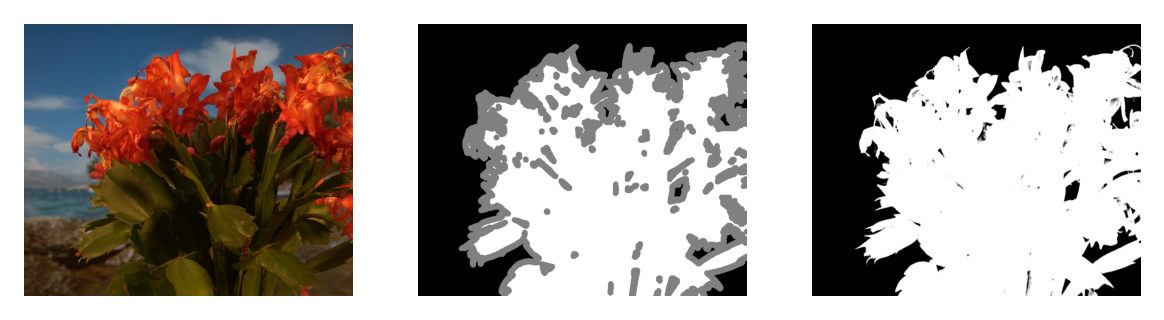

In [17]:
# Sample images path
merged_path = './data/alphamatting/merged/GT21.png'
trimap_path = './data/alphamatting/trimap/Trimap1/GT21.png'
alpha_path = './tutorial_exps/indexnet/results/GT21.png'

# Plot sample images
merged = mmcv.imread(merged_path)
trimap = mmcv.imread(trimap_path)
alpha = mmcv.imread(alpha_path)
f, axarr = plt.subplots(1, 3)
f.dpi = 240
axarr[0].axis('off')
axarr[0].imshow(mmcv.bgr2rgb(merged))
axarr[1].axis('off')
axarr[1].imshow(trimap)
axarr[2].axis('off')
axarr[2].imshow(alpha)

Congratulations! You've done the tutorial for using MMEditing for matting task. Go to [Getting Started page](https://github.com/open-mmlab/mmediting/blob/master/docs/getting_started.md) for more usage of MMEditing and start to train your own mattor!